>### 🚩 *Create a free WhyLabs account to get more value out of whylogs!*<br> 
>*Did you know you can store, visualize, and monitor whylogs profiles with the [WhyLabs Observability Platform](https://whylabs.ai/whylogs-free-signup?utm_source=whylogs-Github&utm_medium=whylogs-example&utm_campaign=KS_profiling)? Sign up for a [free WhyLabs account](https://whylabs.ai/whylogs-free-signup?utm_source=whylogs-Github&utm_medium=whylogs-example&utm_campaign=KS_profiling) to leverage the power of whylogs and WhyLabs together!*

# Benchmark - KS Test

> This notebook is a complement to the blog post "_Drift Detection meets Data Profiling - Experiments on KS Test for profiled data_"*.
>
>Please refer to the blog post for additional context.
>
>
>*The blog post is currently unpublished. We'll update this notebook when it gets released. 


We applied whylogs' implementation of KS Test and compared the results when applying the same test to the complete data set. The results allow us to discuss the limitations of data profiling for KS drift detection, and also the pros and cons of the KS algorithm itself for different scenarios.

## Experiment Design

First, we need the data. For this experiment, we will take two samples of equal size from the following distributions:

- Normal: Broad class of data. Unskewed and Peaked around the center

- Pareto: Skewed data with long tail/outliers

- Uniform: Evenly sampled across its domain


### Drift Injection

Next, we’ll inject drift into one sample (which we’ll call the target distribution) to compare it to the reference, unaltered, distribution.

We will inject drift artificially by simply shifting the data according to a parameter. We’ll use as the parameter a ratio of the distribution’s interquartile range.

The idea is to have 4 different scenarios:

- No drift

- Small drift

- Medium drift

- Large drift

The ideal process of detecting/alerting for drifts can be very subjective, depending on the desired sensitivity for your particular application. In this case, we are assuming that the small-drift scenario is small enough for it to be safely ignored. We are also expecting that the medium and large drift scenarios should result in a drift alert since both would be cases for further inspection. 



### Applying the KS test

As the ground truth, we will use scipy’s implementation of the two-sample KS test, with the complete data from both samples. We will then compare those results with the profiled version of the test. To do so, we’ll use whylogs’ implementation of the same test, which uses only the statistical profile of each sample. 

The distribution metrics contained in the profiles are obtained from a process called data sketching, which adds some degree of randomness to the result. For this reason, the KS test result can be different each time a profile is generated. For this reason, we’ll profile the data 10 times for every scenario, and compare the ground truth to statistics such as the mean, maximum, and minimum of those runs.


### Experiment Variables

Our main goal is to answer:

“How does whylogs’ KS implementation compare to scipy’s implementation?”

However, this answer depends on several different variables. We will run three separate experiments to better understand the effect of each variable: Data Volume, Number of buckets, and Profile Size. The first one relates to the number of samples being tested, whereas the last two relate to whylogs internal, tunable parameters.


## Parameters and Functions - Experiments and Plots

In this section, we'll compile all of the parameter and functions required to run the following experiments and plot the results.

In [1]:
import numpy as np
# For experiment #2, we're running the test with different number of buckets for the KS Test calculation
QUANTILE_LIST = [
    list(np.linspace(0,1,5)),
    list(np.linspace(0,1,10)),
    list(np.linspace(0,1,50)),
    list(np.linspace(0,1,100)),
]

# no drift, small drift, medium drift and large drift
drift_magnitudes = [0,0.05,0.4,0.75]

In [2]:
from numpy.random import Generator, PCG64
import pandas as pd
from scipy.stats import iqr

def generate_data(
    distribution: str = "normal", generator=None, drift_magnitude: float = 0, size: int = 100000
) -> pd.Series:
    """Generates a pandas series with samples drawn from a distribution (normal, pareto or uniform). The internal parameters
    for each distributions are fixed. You can specify the number of samples you want and also if a drift of a certain magnitude is
    to be injected. The drift magnitude is a ratio of the distribution's interquartile range.

    """
    if generator is None:
        generator = Generator(PCG64(12345))

    if distribution == "normal":
        sample = generator.standard_normal(size)
    elif distribution == "pareto":
        a,m = 7.,2.
        sample = (generator.pareto(a, size) + 1) * m
    elif distribution == "uniform":
        sample = generator.uniform(-5,5,size)
    else:
        raise ValueError("Distribution not found.")
    offset = (iqr(sample)) * drift_magnitude
    drifted_sample = sample + offset
    return pd.Series(drifted_sample)

In [3]:
from statistics import mean, stdev
from numpy.random import default_rng
from numpy.random import Generator, PCG64
import numpy as np
from typing import Tuple
import pandas as pd
import whylogs as why
from whylogs.viz.utils.drift_calculations import calculate_drift_values, _compute_ks_test_p_value
from scipy import stats

def run_ks_experiment(distribution="normal",drift_magnitude=0, quantile_list = QUANTILE_LIST):
    """Runs KS experiment for given distribution type and drift magnitude. The experiments are run
    for multiple sample sizes and number of buckets, 10 times for each combination of parameters.

    Parameters
    ----------
    distribution : str, optional
        distribution type. "normal","pareto", or "uniform", by default "normal"
    drift_magnitude : int, optional
        drift magnitude, by default 0 (no drift)

    Returns
    -------
    _type_
        Dictionary with statistics such as pvalues for whylogs and scipy's implementation, mean absolute errors,
        and error ranges (minimum and maximum) for whylogs KS test.
    """
    size_list = [1000, 5000, 10000, 50000, 100000]
    experiment_results = {}
    for quant_i,QUANTILES in enumerate(quantile_list):
        bars1 = []
        heights1 = []
        pv_means = []
        pv_ranges = []
        pv_truths = []
        for sample_size in size_list:
            rng = Generator(PCG64(42))
            ref, target = pd.DataFrame(), pd.DataFrame()
            ref["col"] = generate_data(distribution=distribution, generator=rng, drift_magnitude=0, size=sample_size)
            target["col"] = generate_data(distribution=distribution, generator=rng, drift_magnitude=drift_magnitude, size=sample_size)
            scipy_res = stats.ks_2samp(ref["col"], target["col"])
            scipy_pvalue = round(scipy_res.pvalue,5)
            errors = []
            pvalues = []
            for i in range(10):
                ref_profile = why.log(ref).profile()
                ref_view = ref_profile.view()

                target_profile = why.log(target).profile()
                target_view = target_profile.view()

                ref_dist = ref_profile._columns["col"]._metrics["distribution"].kll.value
                target_dist = target_profile._columns["col"]._metrics["distribution"].kll.value

                res = _compute_ks_test_p_value(reference_distribution=ref_dist, target_distribution=target_dist, quantiles=QUANTILES)
                pv = round(res["p_value"],5)
                error = round(abs(res["p_value"] - scipy_pvalue),5)
                errors.append(error)
                pvalues.append(pv)
            mean = round(sum(errors) / len(errors),5)
            mean_pv = sum(pvalues) / len(pvalues)

            range_pv = [round(abs(mean_pv-min(pvalues)),5),round(abs(mean_pv-max(pvalues)),5)] 
            error = [abs(mean-min(errors)),abs(mean-max(errors))]

            pv_truth = scipy_pvalue
            pv_truths.append(pv_truth)
            bars1.append(mean)
            heights1.append(error)

            pv_means.append(mean_pv)
            pv_ranges.append(range_pv)

        y_err = [[x[0] for x in heights1],[x[1] for x in heights1]]
        pv_rg = [[x[0] for x in pv_ranges],[x[1] for x in pv_ranges]]

        experiment_results[quant_i] = {}
        experiment_results[quant_i]['bar'] = bars1
        experiment_results[quant_i]['yerr'] = y_err
        experiment_results[quant_i]['pv_means'] = pv_means
        experiment_results[quant_i]['pv_ranges'] = pv_rg
        experiment_results[quant_i]['pv_truths'] = pv_truths
        experiment_results[quant_i]['label'] = "buckets={}".format(len(QUANTILES))
        experiment_results[quant_i]['distribution'] = distribution
    return experiment_results

def run_experiment_on_params(distribution="normal",magnitudes = drift_magnitudes):
    """
    Runs the KS experiment for a list of different drift magnitudes
    """
    exps_results = {}

    for drift_magnitude in magnitudes:
        exps_results[drift_magnitude] = run_ks_experiment(distribution=distribution, drift_magnitude=drift_magnitude)

    return exps_results

In [4]:
from statistics import mean, stdev
from numpy.random import default_rng
from numpy.random import Generator, PCG64
import numpy as np
from typing import Tuple
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_drift(distribution="normal", magnitudes = [0,0.05,0.4,0.75], sample_size = 100000):
    """Plots 4 histograms in a 2x2 matrix for different drift magnitudes, for the given distribution type
    and number of samples.
    """

    rng = Generator(PCG64(42))
    fig, axs = plt.subplots(2,2)
    fig.tight_layout(pad=1.5)
    for ix,drift_magnitude in enumerate(magnitudes):
        x,y = int(ix%2),int(ix/2)

        df = pd.DataFrame()

        df["ref"] = generate_data(distribution=distribution, generator=rng, drift_magnitude=0, size=sample_size)
        df["target"] = generate_data(distribution=distribution, generator=rng, drift_magnitude=drift_magnitude, size=sample_size)



        # set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above)
        sns.set(style="darkgrid")

        sns.histplot(ax=axs[x][y],data=df, x="ref", color="skyblue", label="ref", kde=False)
        sns.histplot(ax=axs[x][y],data=df, x="target", color="red", label="target", kde=False)
        if ix==2:
            axs[x][y].legend(loc=0, prop={'size': 12})
        axs[x][y].set_xlabel('Drift Size:{}'.format(drift_magnitude))

    fig.text(.5, -0.05, "Artificial drift injection for varying drift magnitudes for {} distribution. Number of samples: {}".format(distribution,sample_size),  ha='center',fontsize=10)
    plt.show()


In [5]:
def plot_pvalues(quant_bars_per_drift):
    """Plots the pvalues for both whylogs and scipy's implementation for
    different drift magnitudes. Expects 4 different drift magnitudes to
    plot a 2x2 matrix.

    Parameters
    ----------
    quant_bars_per_drift : dict
        Statistics previously collected by KS experiment.
    """
    fig, axs = plt.subplots(2,2)
    fig.tight_layout(pad=1.0)

    for i,key in enumerate(quant_bars_per_drift): 
        quant_bars = quant_bars_per_drift[key]
        # whylogs by default uses 100 buckets, so let's choose that
        quant_index = 3
        x,y = int(i%2),int(i/2)
        pv_means = quant_bars[quant_index]['pv_means']
        pv_range = quant_bars[quant_index]['pv_ranges']
        pv_truth = quant_bars[quant_index]['pv_truths']


        r1 = np.arange(len(pv_means))
        # r2 = [x+ix*barWidth for x in r1]
        axs[x][y].set_xticks([r for r in range(len(quant_bars[quant_index]['bar']))], ['1k', '5k', '10k','50k','100k'])
        axs[x][y].errorbar(r1, pv_means, yerr=pv_range, capsize=7, label="whylogs")
        axs[x][y].set_ylabel('pvalue')
        axs[x][y].plot(r1,pv_truth, label="scipy")
        if i==2:
            axs[x][y].legend(loc=1, prop={'size': 12})
        axs[x][y].set_xlabel('Drift Size:{}'.format(key))
        axs[x][y].set_ylim(bottom=0)


    fig.text(.5, -0.05, "KS pvalue comparison between whylogs and scipy. K=1024, 100 buckets, {} distribution".format(quant_bars[quant_index]['distribution']),  ha='center',fontsize=10)
    plt.show()

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_buckets_experiment(quant_bars_per_drift):
    """Plots the mean absolute errors for different number of buckets for
    different drift magnitudes. Expects 4 different drift magnitudes to
    plot a 2x2 matrix. The errors are calculated based on the difference
    between whylogs' and scipy's KS implementation.

    Parameters
    ----------
    quant_bars_per_drift : dict
        Statistics previously collected by KS experiment.
    """

    fig, axs = plt.subplots(2,2)
    fig.tight_layout(pad=1.0)
    barWidth = 0.17
    # this plots 4 subplots in a 2x2 matrix
    assert len(quant_bars_per_drift)==4
    for i,drift_magnitude in enumerate(quant_bars_per_drift):
        quant_bars = quant_bars_per_drift[drift_magnitude]
        x,y = int(i%2),int(i/2)


        for ix,key in enumerate(quant_bars):
            r1 = np.arange(len(quant_bars[key]['bar']))
            r2 = [x+ix*barWidth for x in r1]
            axs[x][y].bar(r2, quant_bars[key]['bar'], width = barWidth, edgecolor = 'black', yerr=quant_bars[key]['yerr'], label=quant_bars[key]['label'])
        
        # general layout
        axs[x][y].tick_params(axis='both', which='major', labelsize=6)
        axs[x][y].set_xticks([r+1.5*barWidth for r in range(len(quant_bars[key]['bar']))], ['1k', '5k', '10k','50k','100k'])
        axs[x][y].set_ylabel('error')
        if i==2:
            axs[x][y].legend(loc=1, prop={'size': 6})
        axs[x][y].set_xlabel('Drift Size:{}'.format(drift_magnitude))
        axs[x][y].set_ylim(bottom=0)
    fig.text(.5, -0.05, "KS pvalue mean abs. error according to sample size for {} distribution and varying drift magnitudes. K=1024".format(quant_bars[key]['distribution']), ha='center',fontsize=10)


    plt.show()


In [7]:
from whylogs.core.resolvers import Resolver
from whylogs.core.datatypes import DataType, Fractional, Integral
from typing import Dict, List, TypedDict
from whylogs.core.metrics import StandardMetric
from whylogs.core.metrics.metrics import Metric
import whylogs as why
from whylogs.core import DatasetSchema
from whylogs.core import MetricConfig
import io
import pandas as pd


class DataFrameSize(TypedDict):
    sample_frac: float
    number_samples: int
    number_bytes: int


class MyCustomResolver(Resolver):
    """Resolver that assigns DistributionMetric to every column (which is ok because we only have one numerical column)."""

    def resolve(self, name: str, why_type: DataType, column_schema) -> Dict[str, Metric]:
        metrics: List[StandardMetric] = [StandardMetric.distribution]

        result: Dict[str, Metric] = {}
        for m in metrics:
            result[m.name] = m.zero(column_schema.cfg)
        return result

def get_parquet_size(df: pd.DataFrame, frac) -> int:
    """Get the size in bytes of a serialized pandas DF
    in parquet format. This is only used when comparing
    profiling vs. sampling results.

    Returns
    -------
    int
        number of bytes of serialized dataframe.
    """
    res = DataFrameSize()
    with io.BytesIO() as buffer:
        df_sampled = df.sample(frac=frac)
        df_sampled.to_parquet(buffer)
        number_bytes = buffer.tell()
        sample_frac = frac
        number_samples = len(df_sampled)
        return DataFrameSize(sample_frac=sample_frac,number_bytes=number_bytes,number_samples=number_samples)

In [8]:
import numpy as np
from numpy.random import Generator, PCG64
import pandas as pd

def get_kll_size_map(kll_list:list):
    """
    This is just to find the proper number of samples and size in bytes to match sizes between profiles and sampled dataframes.
    Distribution type does not affect significantly the output.
    """
    rng = Generator(PCG64(42))
    distribution="normal"
    sample_size = 100000
    drift_magnitude = 0
    ref, target = pd.DataFrame(), pd.DataFrame()
    ref["col"] = generate_data(distribution=distribution, generator=rng, drift_magnitude=0, size=sample_size)
    kllSizeMap = {}
    for kll_val in kll_list:
        ref_view = why.log(ref, schema=DatasetSchema(default_configs=MetricConfig(kll_k_large=kll_val),resolvers=MyCustomResolver())).profile().view()
        ref_size = len(ref_view.serialize())
        closest_sample = DataFrameSize()
        distance = 10000000
        # closest_sample['distance'] = 1000000
        for frac in list(np.linspace(0.0001,0.2,200)):
            sample_size = get_parquet_size(ref,frac=frac)
            if abs(dist:=ref_size-sample_size["number_bytes"]) < distance:
                closest_sample = sample_size
                distance = dist 
        # print("Closest sample for kll = {} is: {}".format(kll_val,closest_sample))
        kllSizeMap[kll_val] = closest_sample
    return kllSizeMap

kll_list = [256,512,1024,2048,4096]
kllSizeMap = get_kll_size_map(kll_list=kll_list)

In [9]:
from scipy import stats
from scipy.special import kl_div
from whylogs.viz.utils.drift_calculations import calculate_drift_values

def run_kll_experiment(distribution="normal", magnitudes = [0,0.01,0.05,0.1], kllSizeMap:dict = {}):
    """Runs experiment on different KLL_K parameters.    

    Parameters
    ----------
    distribution : str, optional
        distribution type. normal, pareto or uniform, by default "normal"
    magnitudes : list, optional
        drift magnitudes, by default [0,0.01,0.05,0.1]
    kllSizeMap : dict, optional
        Relation between profile and sampled df for a given KLL_K, by default {}

    Returns
    -------
    dict
        Statistics such as errors and size in KB for different KLL_K parameters for profile case,
        and for dfs sampled on different ratios for sampling case.
    """
    kll_list = [int(key) for key in kllSizeMap]
    sample_size = 100000
    kll_bars = {}
    for drift_magnitude in magnitudes:
        rng = Generator(PCG64(42))
        kll_bars[drift_magnitude] = {}
        ref, target = pd.DataFrame(), pd.DataFrame()
        ref["col"] = generate_data(distribution=distribution, generator=rng, drift_magnitude=0, size=sample_size)
        target["col"] = generate_data(distribution=distribution, generator=rng, drift_magnitude=drift_magnitude, size=sample_size)

        for kll_val in kll_list:
            kll_bars[drift_magnitude][kll_val] = {}
            scipy_res = stats.ks_2samp(ref["col"], target["col"])
            scipy_pvalue = round(scipy_res.pvalue,5)
            profiled_pvalues = []
            sampled_pvalues = []
            for i in range(10):
                ref_profile = why.log(ref, schema=DatasetSchema(default_configs=MetricConfig(kll_k_large=kll_val),resolvers=MyCustomResolver())).profile()
                ref_view = ref_profile.view()

                target_profile = why.log(target, schema=DatasetSchema(default_configs=MetricConfig(kll_k_large=kll_val),resolvers=MyCustomResolver())).profile()
                target_view = target_profile.view()

                profiled_pvalue = round(calculate_drift_values(target_view=target_view, reference_view=ref_view)['col']['p_value'],5)

                ref_sampled = ref.sample(frac=kllSizeMap[kll_val]['sample_frac'])
                target_sampled = target.sample(frac=kllSizeMap[kll_val]['sample_frac'])

                sampled_pvalue = round(stats.ks_2samp(ref_sampled["col"], target_sampled["col"]).pvalue,5)

                profiled_pvalues.append(profiled_pvalue)
                sampled_pvalues.append(sampled_pvalue)
            size_bytes = kllSizeMap[kll_val]['number_bytes']
            size_kb = int(size_bytes/1000)
            profile_errors = [abs(pv-scipy_pvalue) for pv in profiled_pvalues]
            sample_errors = [abs(pv-scipy_pvalue) for pv in sampled_pvalues]

            profile_mean = sum(profile_errors)/len(profile_errors)
            sample_mean = sum(sample_errors)/len(sample_errors)

            range_profile_errors = [abs(profile_mean-min(profile_errors)),abs(profile_mean-max(profile_errors))] 
            range_sample_errors = [abs(sample_mean-min(sample_errors)),abs(sample_mean-max(sample_errors))] 

            kll_bars[drift_magnitude][kll_val]['size_kb'] = size_kb
            kll_bars[drift_magnitude][kll_val]['profile_bars'] = profile_mean
            kll_bars[drift_magnitude][kll_val]['sample_bars'] = sample_mean
            kll_bars[drift_magnitude][kll_val]['profile_yerr'] = range_profile_errors
            kll_bars[drift_magnitude][kll_val]['sample_yerr'] = range_sample_errors
            kll_bars[drift_magnitude][kll_val]['distribution'] = distribution
    return kll_bars

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def plot_kll_experiment(bars_per_kll_per_drift, include_sampling=True):
    """Plots kll experiments for different magnitudes (expects 4).

    Parameters
    ----------
    bars_per_kll_per_drift : dict
        KLL Experiment results.
    include_sampling : bool, optional
        If false, plots only errors for the profiling case, by default True
    """
    fig, axs = plt.subplots(2,2)
    fig.tight_layout(pad=1.0)
    barWidth = 0.17
    for i,drift_magnitude in enumerate(bars_per_kll_per_drift):
        x,y = int(i%2),int(i/2)
        bars_per_kll = bars_per_kll_per_drift[drift_magnitude] 
        profile_bars = [bars_per_kll[key]['profile_bars'] for key in bars_per_kll]
        sample_bars = [bars_per_kll[key]['sample_bars'] for key in bars_per_kll]
        
        profile_error = [[bars_per_kll[key]['profile_yerr'][0] for key in bars_per_kll],[bars_per_kll[key]['profile_yerr'][1] for key in bars_per_kll]]
        size_kb = ["{} KB".format(bars_per_kll[key]['size_kb']) for key in bars_per_kll]

        r1 = np.arange(len(profile_bars))
        r2 = [x + barWidth for x in r1]

        if include_sampling:
            sample_error = [[bars_per_kll[key]['sample_yerr'][0] for key in bars_per_kll],[bars_per_kll[key]['sample_yerr'][1] for key in bars_per_kll]]
            axs[x][y].bar(r2, sample_bars, color='tab:blue', yerr = sample_error, width=barWidth,label='Sampled')
            axs[x][y].set_xticks([r+1*barWidth for r in range(len(profile_bars))], size_kb)
        else:
            axs[x][y].set_xticks([r for r in range(len(profile_bars))], size_kb)
        axs[x][y].tick_params(axis='both', which='major', labelsize=6)
        axs[x][y].bar(r1, profile_bars, color='tab:orange', yerr = profile_error, width=barWidth,label='Profiled')
        axs[x][y].set_xlabel('Drift Size:{}'.format(drift_magnitude))
        axs[x][y].set_ylabel('error')
        axs[x][y].set_ylim(bottom=0)

        if i==2:
            axs[x][y].legend(loc=1)
    first_key = list(bars_per_kll.keys())[0]
    if include_sampling:
        fig.text(.5, -0.05, "KS pvalue mean abs. error comparison between profiling and sampling. {} distribution. Sample size = 100 000.".format(bars_per_kll[first_key]['distribution']),  ha='center',fontsize=10)
    else:
        fig.text(.5, -0.05, "KS pvalue mean abs. error for profiling. {} distribution. Sample size = 100 000.".format(bars_per_kll[first_key]['distribution']),  ha='center',fontsize=10)

    plt.show()

## Normal Distribution

### Drift Injection

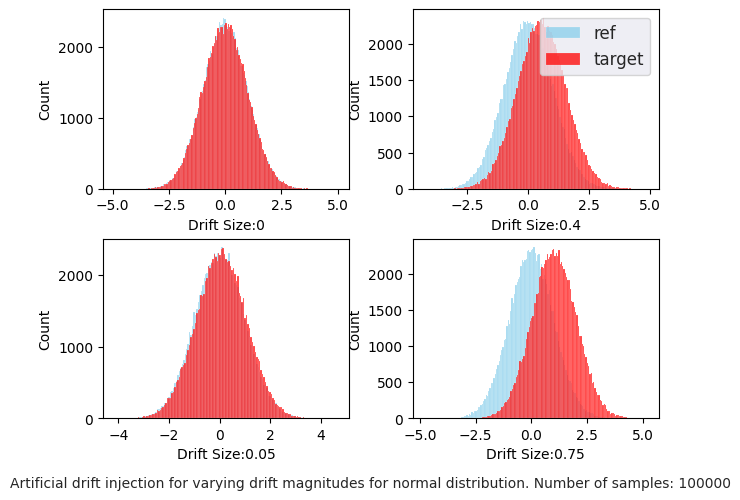

In [11]:
plot_drift(distribution="normal", magnitudes=drift_magnitudes)

### Running the Experiment

In [12]:
quant_bars_per_drift = run_experiment_on_params(distribution="normal",magnitudes = drift_magnitudes)

### Experiment #1 - Data Volume

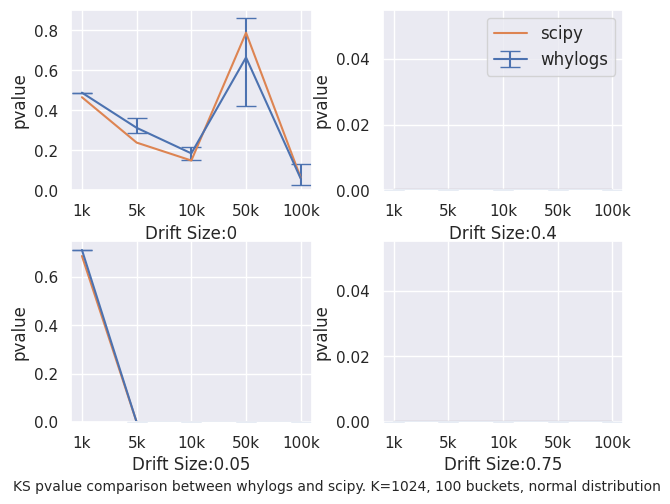

In [13]:
plot_pvalues(quant_bars_per_drift)

### Experiment #2 - No. of Buckets

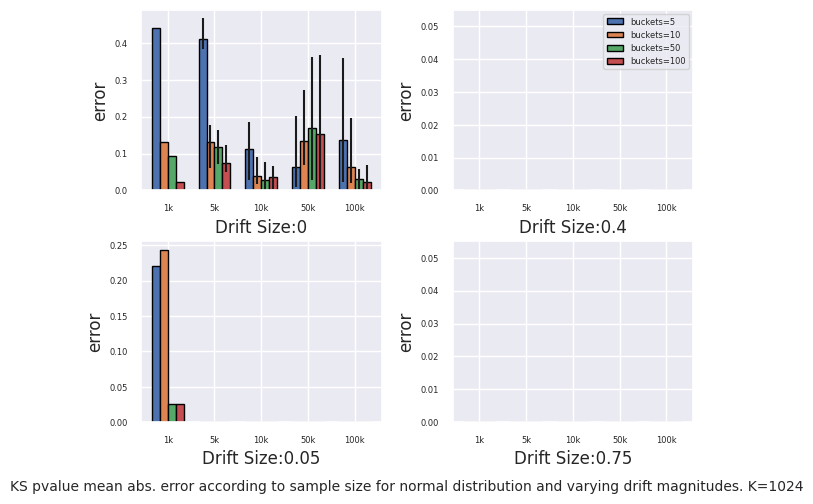

In [14]:
plot_buckets_experiment(quant_bars_per_drift)

- sensitive enough to get very small drift magnitude
- overall trend the same, ground truth pretty much within profiling empirical error bounds
- all but one point would yield the same result (drift/no-drift)
- last point for no drift is arguably wrong, as there's no drift
- oddly enough, even though whylogs is further from the ground truth, it is closer to the expected value, which is no drift (for the first case)

### Experiment #3 - Profile Size

In [15]:
kll_bars = run_kll_experiment(distribution="normal",magnitudes=drift_magnitudes, kllSizeMap=kllSizeMap)

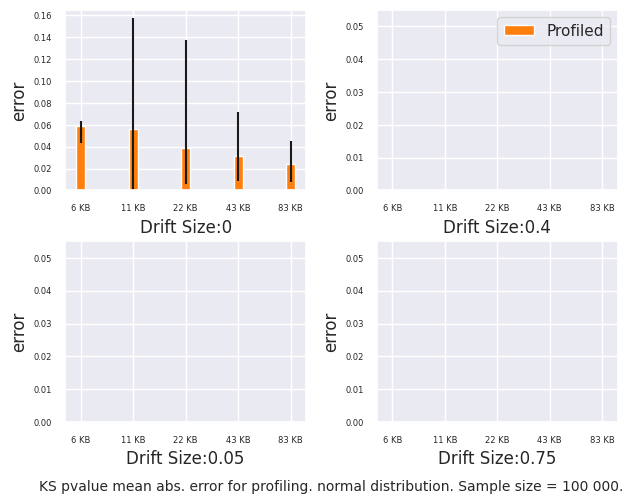

In [16]:
plot_kll_experiment(kll_bars, include_sampling=False)

- Error inversely proportional to Profile Size: By increasing the profile size, the errors due to profiling decreases, and it gets closer to the standard approach.
- again, KS is so sensitive that when any drift is present, both approaches go directly to 0

## Pareto Distribution

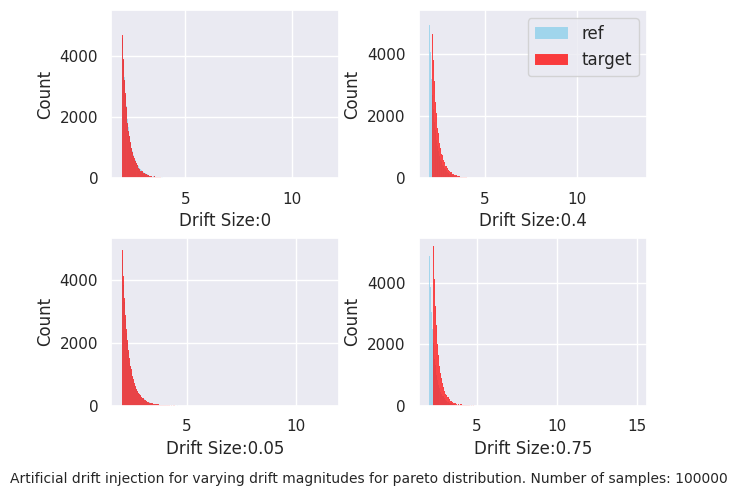

In [17]:
plot_drift(distribution="pareto", magnitudes=drift_magnitudes)

### Running the Experiments

In [18]:
quant_bars_per_drift = run_experiment_on_params(distribution="pareto",magnitudes = drift_magnitudes)

### Experiment #1 - Data Volume

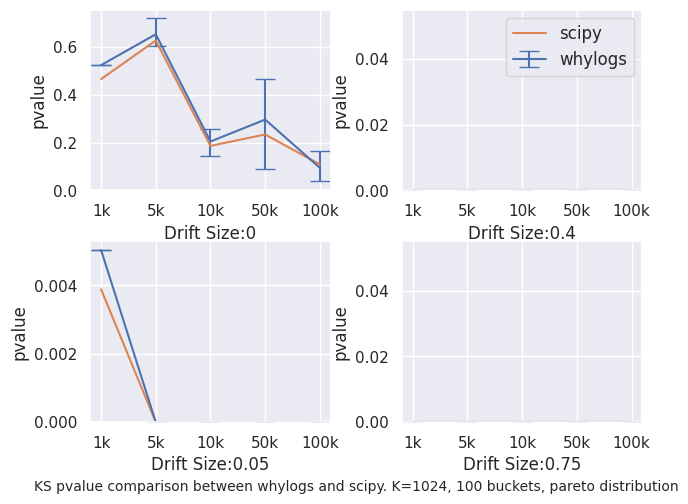

In [19]:
plot_pvalues(quant_bars_per_drift)

### Experiment #2 - No. of Buckets

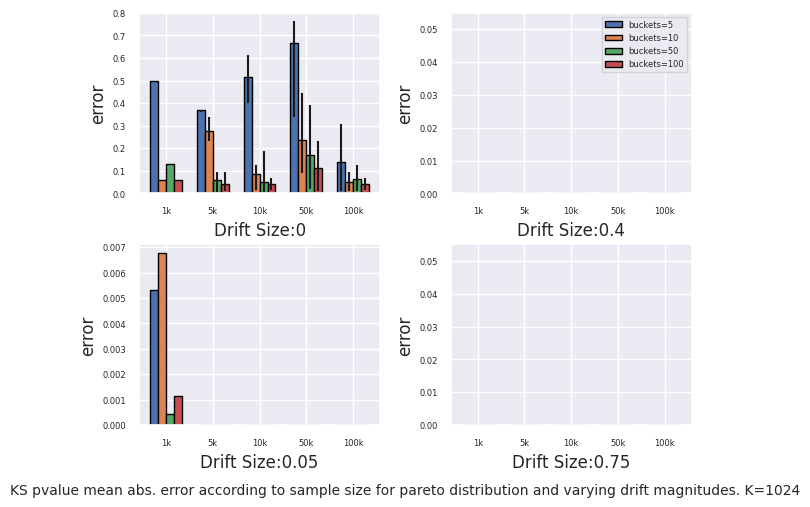

In [20]:
plot_buckets_experiment(quant_bars_per_drift)

### Experiment #3 - Profile Size

In [21]:
kll_bars = run_kll_experiment(distribution="pareto",magnitudes=drift_magnitudes, kllSizeMap=kllSizeMap)

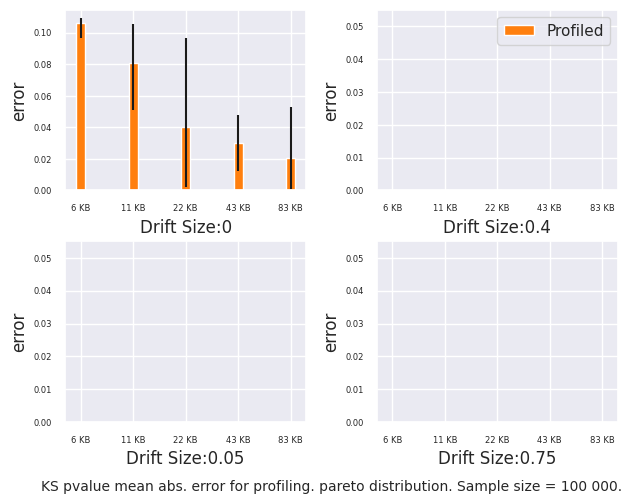

In [22]:
plot_kll_experiment(kll_bars, include_sampling=False)

## Uniform Distribution

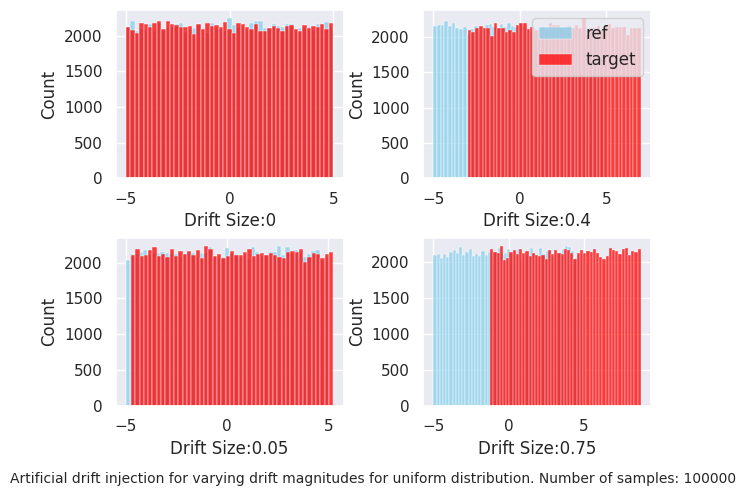

In [23]:
plot_drift(distribution="uniform", magnitudes=drift_magnitudes)

### Running the Experiment

In [24]:
quant_bars_per_drift = run_experiment_on_params(distribution="uniform",magnitudes = drift_magnitudes)

## Experiment #1 - Data Volume

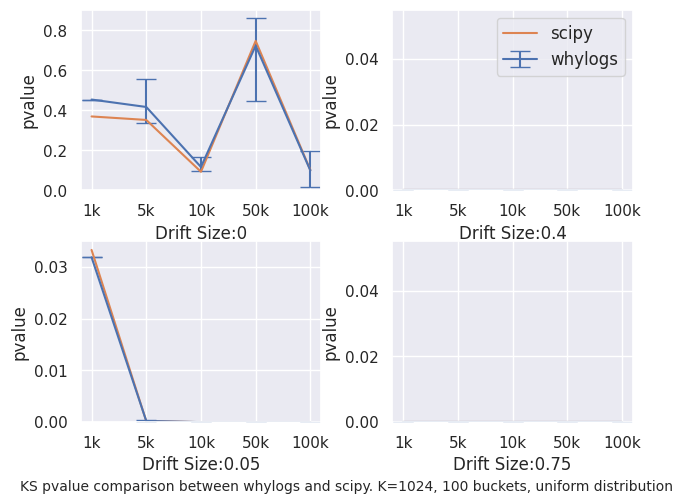

In [25]:
plot_pvalues(quant_bars_per_drift)

### Experiment #2 - No. of buckets

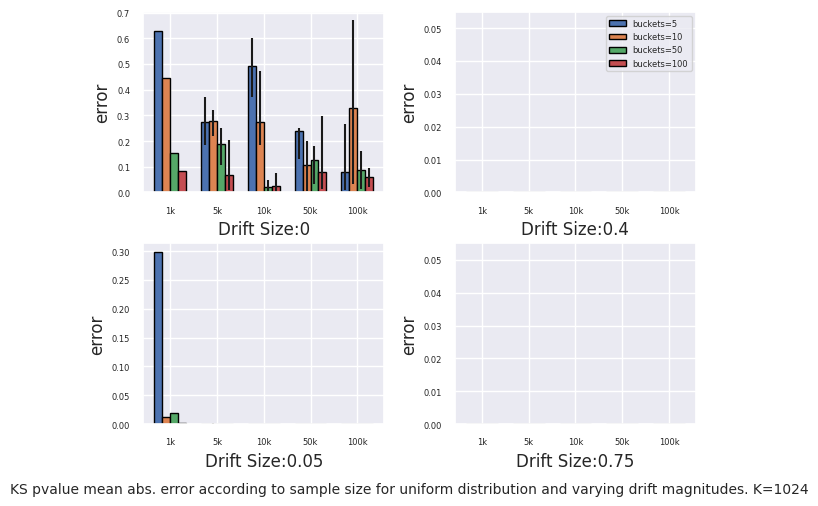

In [26]:
plot_buckets_experiment(quant_bars_per_drift)

### Experiment #3 - Profile Size

In [27]:
kll_bars = run_kll_experiment(distribution="uniform",magnitudes=drift_magnitudes, kllSizeMap=kllSizeMap)

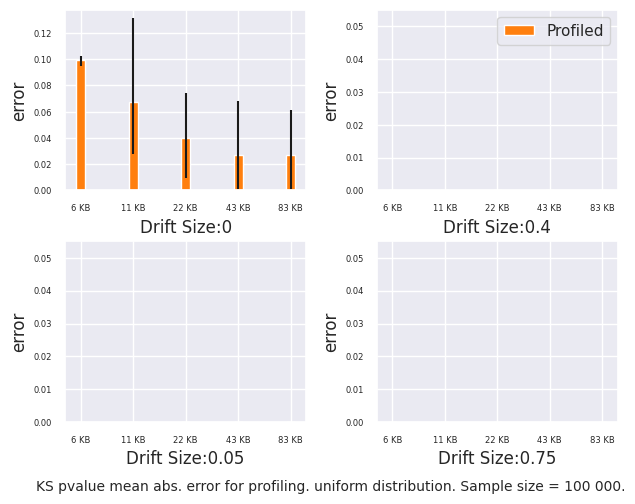

In [28]:
plot_kll_experiment(kll_bars, include_sampling=False)